In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from shutil import copyfile

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [15]:
drive_path = "/content/drive/MyDrive/AI/Colabs/CV/local-soup-classifier"

data_dir = drive_path + "/datasets"
train_dir = data_dir + "/train"
val_dir = data_dir + "/val"

In [16]:
os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [5]:
# def process_images(test_size):
    # src = drive_path + "/dataset"

    # count = 0
    # for folder in os.listdir(src): 
    #     if folder == '.DS_Store':
    #         continue
        
    #     count = 0
    #     val_size = 0
    #     sub_dir = src + '/' + folder

    #     _, _, files = next(os.walk(sub_dir))
    #     val_size = int(test_size * len(files))
    #     print(f'Val size: {val_size}')

    #     for file in os.listdir(sub_dir):
    #         img_path = sub_dir + '/' + file
    #         new_filename = "/" + folder + '_' + str(count) + '.jpeg'
    #         full_path = val_dir + new_filename

    #         if count >= val_size: 
    #           full_path = train_dir + new_filename
    #           print(f'train path: {full_path}')

    #         copyfile(img_path, full_path)
    #         count += 1

In [17]:
def process_images(test_size):
    old_src = drive_path + "/dataset"

    count = 0
    for folder in os.listdir(old_src): 
        if folder == '.DS_Store':
            continue
        
        
        sub_dir = old_src + '/' + folder

        _, _, files = next(os.walk(sub_dir))
        val_size = int(test_size * len(files))
        print(f'Val size: {val_size}')

        count = 0
        val_dirr = val_dir + '/' + folder
        os.makedirs(val_dirr, exist_ok=True)
        for file in os.listdir(sub_dir):
            if count >= val_size:
              break

            img_path = sub_dir + '/' + file
            new_filename = "/" + folder + '_' + str(count) + '.jpeg'
            full_path = val_dirr + new_filename

            copyfile(img_path, full_path)
            count += 1


        count = 0
        train_dirr = train_dir + '/' + folder
        os.makedirs(train_dirr, exist_ok=True)
        for file in os.listdir(sub_dir):
            img_path = sub_dir + '/' + file
            new_filename = "/" + folder + '_' + str(count) + '.jpeg'
            full_path = train_dirr + new_filename

            copyfile(img_path, full_path)
            count += 1

In [18]:
process_images(0.2)

Val size: 12
Val size: 42
Val size: 36
Val size: 26


In [21]:
_, _, files = next(os.walk(train_dir + '/oha'))
print(f'Size: {len(files)}')

Size: 213


In [9]:
# Data augmentation and normalization for training
# Just normalization for validation

data_transforms = {
    'train': transforms.Compose([
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([
                               transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
}

In [10]:
print(train_dir)

/content/drive/MyDrive/AI/Colabs/CV/local-soup-classifier/datasets/train


In [11]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                                          for x in ['train', 'val']
                  }

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
                                          for x in ['train', 'val']
              }
        
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


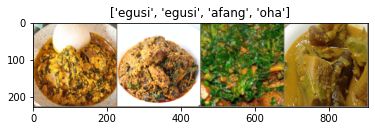

In [12]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training

---



In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

      # deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
  print(f'Best val Acc: {best_acc:4f}')

  # load best model weights
  model.load_state_dict(best_model_wts)
  return model

Visualize the model predictions 

---



In [14]:
def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['val']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.size()[0]):
        images_so_far += 1
        ax = plt.subplot(num_images // 2, 2, images_so_far)
        ax.axis('off')
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])

        if images_so_far == num_images:
          model.train(mode=was_training)
          return
          
    model.train(mode=was_training)


Finetuning the convNet

---



In [15]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Train and Evaluate

---



In [16]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.0364 Acc: 0.5777


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.4629 Acc: 0.8446

Epoch 1/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.9634 Acc: 0.6520


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3128 Acc: 0.8970

Epoch 2/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8849 Acc: 0.6892


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3332 Acc: 0.9071

Epoch 3/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.7666 Acc: 0.7230


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.4409 Acc: 0.8328

Epoch 4/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6993 Acc: 0.7551


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1947 Acc: 0.9426

Epoch 5/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.7830 Acc: 0.7500


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.2375 Acc: 0.9105

Epoch 6/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.7794 Acc: 0.7348


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1926 Acc: 0.9409

Epoch 7/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6242 Acc: 0.7669


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1341 Acc: 0.9611

Epoch 8/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4925 Acc: 0.8226


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1245 Acc: 0.9595

Epoch 9/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4750 Acc: 0.8226


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1202 Acc: 0.9645

Epoch 10/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4702 Acc: 0.8429


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1065 Acc: 0.9679

Epoch 11/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4362 Acc: 0.8446


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0995 Acc: 0.9696

Epoch 12/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4610 Acc: 0.8361


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1372 Acc: 0.9628

Epoch 13/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4374 Acc: 0.8463


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0994 Acc: 0.9730

Epoch 14/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4197 Acc: 0.8497


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1121 Acc: 0.9713

Epoch 15/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4129 Acc: 0.8632


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1226 Acc: 0.9611

Epoch 16/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4268 Acc: 0.8345


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0999 Acc: 0.9696

Epoch 17/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4417 Acc: 0.8328


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1063 Acc: 0.9645

Epoch 18/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4247 Acc: 0.8530


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1087 Acc: 0.9696

Epoch 19/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4111 Acc: 0.8446


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1080 Acc: 0.9696

Epoch 20/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.3998 Acc: 0.8547


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0941 Acc: 0.9730

Epoch 21/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4348 Acc: 0.8294


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0912 Acc: 0.9679

Epoch 22/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4533 Acc: 0.8294


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0971 Acc: 0.9713

Epoch 23/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4278 Acc: 0.8581


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.0925 Acc: 0.9679

Epoch 24/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.4011 Acc: 0.8412


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.1037 Acc: 0.9662

Training complete in 11m 29s
Best val Acc: 0.972973


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


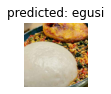

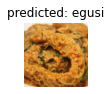

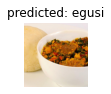

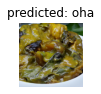

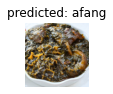

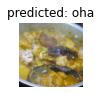

In [17]:
visualize_model(model_ft)

ConvNet as fixed feature extractor

---

Here we freeze all the network except the final layer. We set required_grad=False to freeze the parameters so that the gradients are not computed in backward()

In [18]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 4)

model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Train and Evaluate

In [19]:
model_ft = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 1.0850 Acc: 0.5405


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.5641 Acc: 0.7956

Epoch 1/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.9542 Acc: 0.6250


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.9215 Acc: 0.6537

Epoch 2/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.9462 Acc: 0.6199


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.4302 Acc: 0.8345

Epoch 3/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8277 Acc: 0.6605


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.4435 Acc: 0.8378

Epoch 4/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.7690 Acc: 0.7230


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3889 Acc: 0.8699

Epoch 5/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8315 Acc: 0.6807


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.4367 Acc: 0.8480

Epoch 6/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.8404 Acc: 0.6875


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.4165 Acc: 0.8328

Epoch 7/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6892 Acc: 0.7280


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3104 Acc: 0.8953

Epoch 8/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.7231 Acc: 0.7348


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3728 Acc: 0.8564

Epoch 9/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6226 Acc: 0.7686


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3311 Acc: 0.8801

Epoch 10/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.7177 Acc: 0.7196


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3778 Acc: 0.8564

Epoch 11/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6593 Acc: 0.7449


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3214 Acc: 0.8885

Epoch 12/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6673 Acc: 0.7686


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3125 Acc: 0.8784

Epoch 13/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6413 Acc: 0.7601


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.2910 Acc: 0.9088

Epoch 14/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6201 Acc: 0.7669


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3368 Acc: 0.8834

Epoch 15/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6188 Acc: 0.7568


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.2960 Acc: 0.9071

Epoch 16/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6782 Acc: 0.7466


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3484 Acc: 0.8699

Epoch 17/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6243 Acc: 0.7432


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3284 Acc: 0.8818

Epoch 18/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.5939 Acc: 0.7753


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.2991 Acc: 0.8919

Epoch 19/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6722 Acc: 0.7213


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3784 Acc: 0.8581

Epoch 20/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.5847 Acc: 0.7720


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3236 Acc: 0.8936

Epoch 21/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6223 Acc: 0.7635


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3052 Acc: 0.8986

Epoch 22/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6211 Acc: 0.7500


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3330 Acc: 0.8868

Epoch 23/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6867 Acc: 0.7399


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3399 Acc: 0.8666

Epoch 24/24
----------


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


train Loss: 0.6447 Acc: 0.7669


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


val Loss: 0.3126 Acc: 0.8919

Training complete in 10m 5s
Best val Acc: 0.908784


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


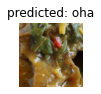

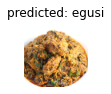

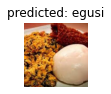

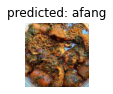

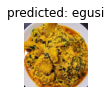

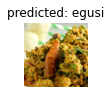

In [20]:
visualize_model(model_conv)

plt.ioff()
plt.show()